# Dataton anticorrupción

1. Limpieza
2. Consorcios
3. Causa de sanciones
4. Los funcionarios sancionados
5. Lugares

Este grupo de datos contiene información en forma de texto. Es por ello que este primer acercamiento retoma herramientas de análisis de texto. En primer lugar limpiamos los campos para eliminar conjunciones, acentos y terminaciones que no nos interesan del texto. Despues realizamos nubes de texto con las palabras mas frecuentes en la descripción de la causa o motivo de los hechos por los cuales fueron sancionados servidores públicos,  particulares y del Edo.Mex.
Para el estado de mexico incluso pudimos identificar localidades como joquicingo, seguido de ecatepec, naucalpan y tlalnepantla. 
Por otro lado, entre las palabras frecuentes por los que las entidades particulares fueron sancionadas ubicamos problemas con los contratos y a Pemex como una de las entidades gubernamentales.


In [10]:
import json
from os.path import exists

import pandas as pd
import pandas_profiling
from pandas.io.json import json_normalize   

import networkx as nx

import seaborn as sns
import matplotlib.pyplot as plt

# Limpieza

In [2]:
files = {'contrataciones_publicos_edomex':['s2-edomex.json'],
         'contrataciones_publicos':['s2-sfp1.json','s2-sfp2.json','s2-sfp3.json'],
         'sancionados_particulares':['s3-particulares-sfp.json'],
         'sancionados_publicos_edomex':['servidores_publicos_sancionados_edoMex.json'],
         'sancionados_publicos':['servidores_publicos_sancionados_sfp1.json','servidores_publicos_sancionados_sfp2.json']}

for k,data in files.items():
    if exists('data-clean/'+k+'.csv'): print(k, 'done')
    else:
        data = [ json.load(open('data-raw/'+f)) for f in data ]
        data = [ json_normalize(f, max_level=1) for f in data ]
        print([f.shape for f in data])
        df = pd.concat(data, ignore_index=True)
        print(k, df.shape, df.columns)
        #profile = df.profile_report()
        #profile.to_file(output_file='profiles/'+k+'.html')
        df.to_csv('data-clean/'+k+'.csv', index=False)

[(776, 27)]
contrataciones_publicos_edomex (776, 27) Index(['id', 'fechaCaptura', 'ejercicioFiscal', 'idRamo', 'ramo', 'rfc',
       'curp', 'nombres', 'primerApellido', 'segundoApellido', 'genero',
       'tipoArea', 'nivelResponsabilidad', 'tipoProcedimiento',
       'periodoEjercicio.fechaInicial', 'periodoEjercicio.fechaFinal',
       'institucionDependencia.nombre', 'institucionDependencia.siglas',
       'institucionDependencia.clave', 'puesto.nombre', 'puesto.nivel',
       'superiorInmediato.nombres', 'superiorInmediato.primerApellido',
       'superiorInmediato.segundoApellido', 'superiorInmediato.curp',
       'superiorInmediato.rfc', 'superiorInmediato.puesto'],
      dtype='object')
[(40000, 24), (40000, 24), (33795, 24)]
contrataciones_publicos (113795, 24) Index(['id', 'fechaCaptura', 'ejercicioFiscal', 'idRamo', 'ramo', 'nombres',
       'primerApellido', 'segundoApellido', 'genero', 'tipoArea',
       'nivelResponsabilidad', 'tipoProcedimiento', 'tipoActos',
       'per

## Red de consorcios de empresas

Existen contratos donde no compite una sola empresa, sino un grupo de estas se asocia. Estos se pueden encontrar por que empiezan por "Grupo de empresas".
Identificamos una red de colaboración en el archivo de contrataciones de donde podemos identificar grupos de empresas que colaboran 
en grupo y/o consorcio que siempre estén colaborando en la obtención de contratos.
En este caso, los que mas frecuentemente se asocian son empresas relacionadas a la construcción, infraestructura y obras.


In [3]:
from pickle import load
from itertools import combinations

In [4]:
consorcios = load(open('data-clean/consorcios.pkl','rb'))

G = nx.Graph()
for con in consorcios:
    for c in con:
        if c in G.nodes(): G.nodes[c]['weight'] += 1
        else: G.add_node(c, weight=1)
    for s,t in combinations(con,2):
        if (s,t) in G.edges(): G.edges[s,t]['weight'] +=1
        else: G.add_edge(s,t, weight=1)

La mayor parte de los consorcios son mas grandes que los grupos

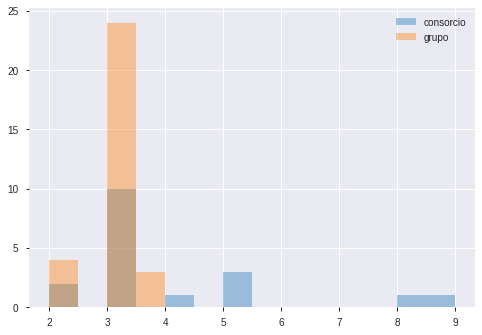

In [5]:
n_con = [len(x) for x in nx.connected_components(G)]
n_gru = [len(x) for x in consorcios]
sns.distplot(n_con, label='consorcio', kde=False, bins=(max(n_con)-min(n_con))*2)
sns.distplot(n_gru, kde=False, label='grupo', bins=(max(n_gru)-min(n_gru))*2)
plt.legend()

Empresas asociadas en grupos principalmente en area de construcción, infraestructura y obra pública

In [6]:
for g in nx.connected_components(G):
    if len(g)>4: print(g)


{'VIP CONSTRUCCIONES', 'CONSTRUCCIONES TEPOCHTLI', 'ARRENDADORA Y CONSTRUCTORA DEL ATOYAC', 'CONSERVACIONES TERRESTRES DE MEXICO ', 'VIP MAQUINARIA', 'CAMINOS Y VOLADURAS DE OAXACA', 'CONSERVACIONES TERRESTRES DE MEXICO', 'INMOBILIARIA BAHIA DEL SUR'}
{'PROYECTOS Y CONSTRUCCIONES HEF', 'SUR CARRETERAS Y ESTRUCTURAS', 'ARMA ODISEA CONSTRUCTORA', 'PROYECTOS INTEGRALES DE MICHOACAN ', 'EDIFICADORA LAGOS', 'MARIASA CONSTRUCCIONES Y CONSTRUCCION INFRAESTRUCTURA Y COMERCIALIZACION', 'CHARY CONSTRUCCIONES', 'COMERCONSTRUYE DE MEXICO', 'MARIASA CONSTRUCCIONES'}
{'GRUPO CONSTRUCTOR SATIRSA', 'PAVIMENTOS Y SERVICIOS EN LA CONSTRUCCION', 'GRUPO TOPO TECNOLOGIA OBRAS Y PAVIMENTOS OPTIMIZADOS', 'CONSTRUCCIONES Y CAMINOS OAXACA E ITAEL CONSTRUCTORA', 'CONSTRUCTORA CRUZER'}
{'ARRENDAMIENTOS DE MAQUINARIA Y PAVIMENTOS ASFALTICOS GARCIA LESCAS EMULSIONES Y PAVIMENTOS DEL PACIFICO', 'PUENTES Y CAMINOS DE OCCIDENTE', 'NHEZ INGENIERIA', 'GRUPO CONSTRUCTOR PRESA CANARIO', 'FELSERK'}
{'SECCION 165 DEL SIND 

Podemos identificar como se agrupan

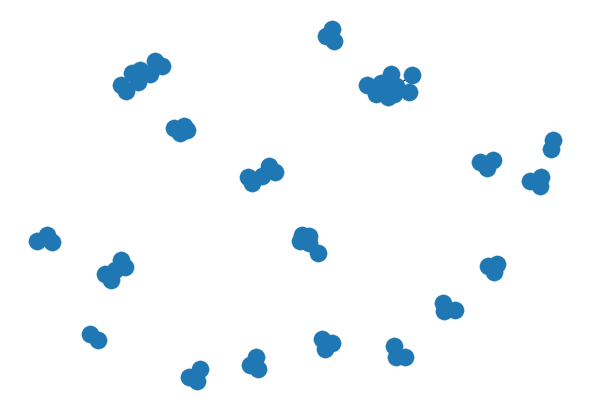

In [7]:
nx.draw(G)

Usando otra base de datos cse puede encontrar un consorcio formado por empresas farmaceuticas

<img src="figures/consorciofarmaceuticas.png">
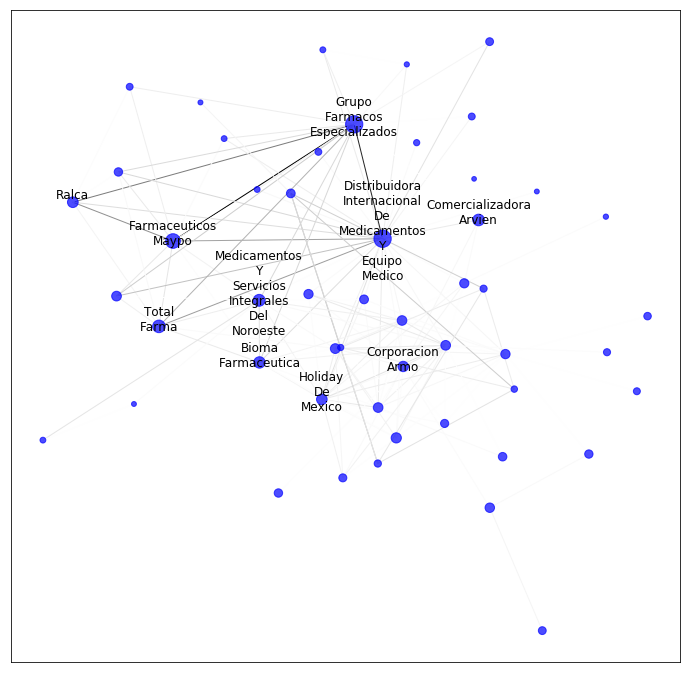

# Cuausas de sanciones

Se puede tambien tratar de encontrar por que razones ha sido sancionado un funcionario. Para esto buscamos que palabras se repiten mas en la descripicon de la sanción para encontrar las sanciones mas comunes. A futuro esto se puede complementar con topic modelling y agrupar por dependencia. 

## Privados sancionados
<img src="figures/privados_sancionados.jpeg">

## Publicos sancionados
<img src="figures/sancionados_publicos.jpeg">

## Sancionados EdoMex
<img src="figures/sancionedomex.jpeg">

In [8]:
from nltk import word_tokenize, download
from nltk.stem import SnowballStemmer
from unidecode import unidecode
import string
download('punkt')
stemmer = SnowballStemmer('spanish')

[nltk_data] Downloading package punkt to /home/esther/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
def clean_and_steam(text):
    stemmed_text = [stemmer.stem(i) for i in word_tokenize(text)]
    text = unidecode(text).translate(str.maketrans('', '', string.punctuation))
    text = ' '.join( [stemmer.stem(i) for i in word_tokenize(text)] )
    return text


sancionados_particulares


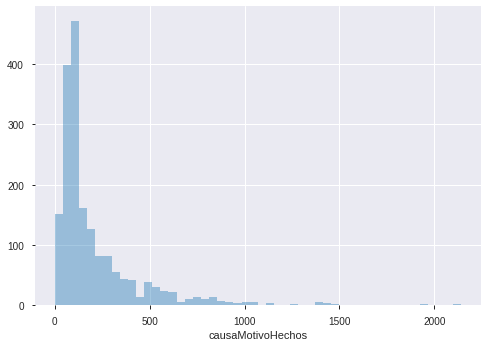

sancionados_publicos_edomex


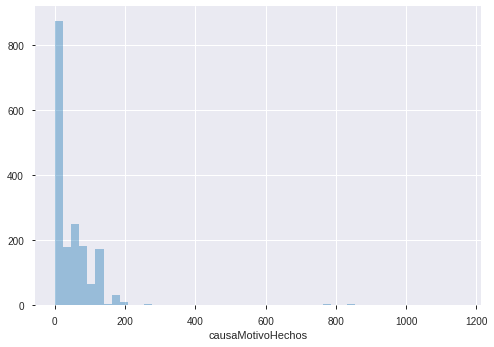

sancionados_publicos


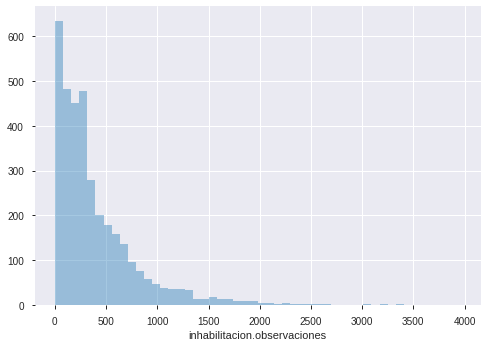

In [10]:
stem_csv = {'sancionados_particulares':'causaMotivoHechos',
            'sancionados_publicos_edomex':'causaMotivoHechos',
            'sancionados_publicos':'inhabilitacion.observaciones'}
for k,v in stem_csv.items():
    print( k )
    df = pd.read_csv('data-clean/'+k+'.csv')
    df[v] = df[v].apply(lambda x: x if type(x)==str else '')
    sns.distplot(df[v].apply(len), kde=False)
    df[v+'Stem'] = df[v].apply(clean_and_steam)
    plt.show()
    df.to_csv('data-clean/'+k+'.csv', index=False)

In [11]:
df = pd.read_csv('data-clean/sancionados_publicos.csv')
text = df['inhabilitacion.observacionesStem'].dropna().to_list()
text = ' '.join(text)
text = text.split(' ')
text = [s for s in text if len(s)>3]
word_freq ={s:text.count(s) for s in set(text)}
for k,v in word_freq.items():
    if v>=500: print(k,v)

general 602
sancion 1022
federal 641
estad 1397
funcion 545
present 543
servici 948
articul 544
cantid 691
public 1604
secretari 658
servidor 616
recurs 619
dich 583
respons 732
autor 891
otorg 521
desempen 576
carg 749
realiz 568
fraccion 602
benefici 601


```
####
# COMO HACER UN WORD CLOUD EN R CON LOS ARCHIVOS DE SANCIONES a SERVIDORES PUBLICOS Y PARTICULARES
#####
# TOMADO DE https://analyticstraining.com/how-to-create-a-word-cloud-in-r/
library(tm)
library(wordcloud)
library(RColorBrewer)
library(dplyr)
speech<-read.csv("/Volumes/NO\ NAME/Anticorrupcion/contrataciones_publicos.csv") 
#speech = "/Volumes/NO\ NAME/Anticorrupcion/sancionados_publicos_edomex.csv"
speech<-select(speech, institucionDependencia.nombre, causaMotivoHechosStem)
speech<-select(speech, institucionDependencia.siglas, inhabilitacion.observacionesStem)
#speech<-as.character(speech)
write.csv(speech, "diciembre2.csv")
speech1 = "/Users/queletzu/Desktop/SCRIPTS/JUZGADOS/diciembre2.csv"
modi_txt = readLines(speech1)
modi<-Corpus(VectorSource(modi_txt))
inspect(modi)[1:10]
modi_data<-tm_map(modi,stripWhitespace)
modi_data<-tm_map(modi_data,tolower)
modi_data<-tm_map(modi_data,removeNumbers)
modi_data<-tm_map(modi_data,removePunctuation)
modi_data<-tm_map(modi_data,removeWords, stopwords("spanish"))
tdm_modi<-TermDocumentMatrix (modi_data) #Creates a TDM
TDM1<-as.matrix(tdm_modi) #Convert this into a matrix format
v = sort(rowSums(TDM1), decreasing = TRUE) #Gives you the frequencies for every word
table(v)
wordcloud (modi_data, scale=c(5,0.5), 
           max.words=100, random.order=FALSE, 
           rot.per=0.35, use.r.layout=FALSE, 
           colors=brewer.pal(8, "Dark2"))
```

# Los sancionados

Encontrar particulares o funcionarios sancionados que dieron contratos, para así poder revisar los contratos

No todos tienen rfc, entonces usamos el nombre y hacemos una estandarizacion rápida con fuzzywuzzy

In [12]:
from utils import *

In [13]:
f_san = {'contrataciones_publicos_edomex':['nombres', 'primerApellido', 'segundoApellido'],
         'contrataciones_publicos':['nombres', 'primerApellido', 'segundoApellido'],
         'sancionados_particulares':['nombreRazonSocial'], 
         'sancionados_publicos_edomex':['servidorPublicoSancionado.nombres','servidorPublicoSancionado.primerApellido','servidorPublicoSancionado.segundoApellido'], 
         'sancionados_publicos':['nombres','primerApellido', 'segundoApellido']}

data = {}
for k,v in f_san.items():
    d = pd.read_csv('data-clean/'+k+'.csv')
    #print(k, d.columns)
    d = d[v].apply(lambda x: ' '.join([i for i in x if type(i)==str]), axis=1).to_list()
    d = set([i for i in d if len(i)>=10])
    data[k] = d
[(k,len(v)) for k,v in data.items()]

[('contrataciones_publicos_edomex', 773),
 ('contrataciones_publicos', 19560),
 ('sancionados_particulares', 1646),
 ('sancionados_publicos_edomex', 1257),
 ('sancionados_publicos', 3096)]

Estandarizar nombres

In [14]:
map_data = generar_diccionario_mapeo(data['contrataciones_publicos_edomex'], data['sancionados_publicos_edomex'], 
                                     warn=90, limit=90)


/home/esther/Documents/anticorrupicion/utils.py:79: UserWarning: 
	IGNORADO: jose angel cruz lopez.
	Opciones: miguel angel hernandez cervantes (86), jose rodolfo jesus garcia borjes (86), ericka lizbeth hernandez de la cruz (86)
  warnings.warn( warn_message )
/home/esther/Documents/anticorrupicion/utils.py:79: UserWarning: 
	IGNORADO: esperanza vazquez diaz.
	Opciones: curicaveri tariyaran pina vazquez (86), alejandroo isaias vazquez hernandez (86), maria de los angeles esperanza garza andrade (86)
  warnings.warn( warn_message )
/home/esther/Documents/anticorrupicion/utils.py:79: UserWarning: 
	IGNORADO: melissa estefania vargas camacho.
	Opciones: raul camacho arispe (86), oscar martinez vargas (86), ana lemus vargas (86)
  warnings.warn( warn_message )
/home/esther/Documents/anticorrupicion/utils.py:79: UserWarning: 
	IGNORADO: raul abarca salgado.
	Opciones:  delgado  (64), maria luisa salgado valdez (64), sergio abarca amaro (63)
  warnings.warn( warn_message )
/home/esther/Docu

Funcionarios o particulares sancionados que dieron contrataciones 

In [15]:
sancionados = data['contrataciones_publicos_edomex'].union(data['contrataciones_publicos']) \
             .intersection(data['sancionados_particulares'].union(data['sancionados_publicos_edomex'],data['sancionados_publicos']))
sancionados

{'ALEJANDRO GARCIA GONZALEZ',
 'ALFREDO HERNANDEZ LOPEZ',
 'ARTURO VILLEGAS MARQUEZ',
 'ISMAEL MONROY ESPINOZA',
 'JORGE LOPEZ RAMIREZ',
 'JORGE SANCHEZ MARTINEZ',
 'JOSE LUIS GARCIA FLORES',
 'JUAN MANUEL GARCIA GOMEZ',
 'MARIA TERESA RODRIGUEZ MENDOZA',
 'MARIO RODRIGUEZ DIAZ',
 'RAUL CHAVEZ CHAPINA'}

En el Edo de Mexico

In [16]:
data['contrataciones_publicos_edomex'].intersection(data['sancionados_publicos_edomex'])

{'ISMAEL MONROY ESPINOZA'}

Estos son los contratos en los que están asociados los servidores públicos que encontramos.

In [18]:
df = pd.read_csv('data-clean/contrataciones_publicos.csv')
df['name'] = df[['nombres','primerApellido','segundoApellido']].apply(lambda x: ' '.join([i for i in x if type(i)==str]), axis=1)
df[df['name'].isin(sancionados)]

,id,fechaCaptura,ejercicioFiscal,idRamo,ramo,nombres,primerApellido,segundoApellido,genero,tipoArea,...,institucionDependencia.siglas,institucionDependencia.nombre,institucionDependencia.clave,puesto.nombre,puesto.nivel,superiorInmediato.nombres,superiorInmediato.primerApellido,superiorInmediato.segundoApellido,superiorInmediato.puesto,name
5312,9ceb4920-c9d5-47e8-89f9-ffc3ddebf78a,NaN,2019,6,HACIENDA Y CRÉDITO PÚBLICO,JUAN MANUEL,GARCIA,GOMEZ,M,"['R', 'T']",...,Prodecon,PROCURADURÍA DE LA DEFENSA DEL CONTRIBUYENTE,6/AYI,SUBDIRECCION DE GESTION DE LA CALIDAD Y PROCESOS,N22,ERENDIRA MARIA,TOLEDO,TERRAZAS,"{'nombre': 'ANALISTA DE INSTRUMENTACION', 'niv...",JUAN MANUEL GARCIA GOMEZ
71489,15f78c2a-12ef-4772-a7de-b2bd90f45d96,NaN,2019,8,AGRICULTURA Y DESARROLLO RURAL,JORGE,SANCHEZ,MARTINEZ,M,[],...,SADER,SECRETARÍA DE AGRICULTURA Y DESARROLLO RURAL,8/143,ANALISTA B,8,JORGE ALAN,SALAZAR,ORTEGA,"{'nombre': 'TECNICO ESPECIALIZADO', 'nivel': N...",JORGE SANCHEZ MARTINEZ
84479,342a28e6-fbfa-4df5-84b6-b8175a0a3b4a,NaN,2019,9,COMUNICACIONES Y TRANSPORTES,ALFREDO,HERNANDEZ,LOPEZ,O,"['R', 'R']",...,API Manzanillo,ADMINISTRACIÓN PORTUARIA INTEGRAL DE MANZANILL...,9/J3B,GERENCIA DE INGENIERIA,NaN,NaN,NaN,NaN,"{'nombre': None, 'nivel': None}",ALFREDO HERNANDEZ LOPEZ
86398,fca61b90-ff37-4beb-b194-1ce0f367cbd1,NaN,2019,9,COMUNICACIONES Y TRANSPORTES,ARTURO,VILLEGAS,MARQUEZ,M,['T'],...,SEPOMEX,SERVICIO POSTAL MEXICANO,9/J9E,GERENTE DE PROYECTOS OPERATIVOS,N21,JOANNA LAURA,ABAD,ESPADIN,{'nombre': 'SUBGERENTE DE PROTECCION AMBIENTAL...,ARTURO VILLEGAS MARQUEZ
91290,1ba965c6-a2b4-4d85-997a-d66f7fa699b3,NaN,2019,20,BIENESTAR,JORGE,LOPEZ,RAMIREZ,M,['R'],...,BIENESTAR,SECRETARÍA DE BIENESTAR,20/414,SUBDIRECCION DE VALIDACION DE DESCRIPCIONES Y ...,N11,TERESA DEL ROCIO,GARCIA,CERVANTES,{'nombre': 'DIRECCION DE ANALISIS Y VALIDACION...,JORGE LOPEZ RAMIREZ
91293,92e40bd9-cbe7-49de-82a9-2621e5f6c7bb,NaN,2019,20,BIENESTAR,JORGE,LOPEZ,RAMIREZ,M,[],...,BIENESTAR,SECRETARÍA DE BIENESTAR,20/414,SUBDIRECCION DE VALIDACION DE DESCRIPCIONES Y ...,N11,TERESA DEL ROCIO,GARCIA,CERVANTES,{'nombre': 'DIRECCION DE ANALISIS Y VALIDACION...,JORGE LOPEZ RAMIREZ
91964,fdefc82b-b328-4802-b392-949c0170d10d,NaN,2019,18,ENERGÍA,ALEJANDRO,GARCIA,GONZALEZ,M,"['R', 'T']",...,INEEL,INSTITUTO NACIONAL DE ELECTRICIDAD Y ENERGÍAS ...,18/T0K,INVESTIGADOR J,E3530,ADRIANA,CADENAS,ISLAS,"{'nombre': 'TITULAR DEL AREA DE QUEJAS', 'nive...",ALEJANDRO GARCIA GONZALEZ
92279,6ad102aa-accd-4dd2-a5f5-1058317b59f0,NaN,2019,18,ENERGÍA,MARIA TERESA,RODRIGUEZ,MENDOZA,O,"['R', 'T', 'R', 'C']",...,INEEL,INSTITUTO NACIONAL DE ELECTRICIDAD Y ENERGÍAS ...,18/T0K,JEFE DE DEPARTAMENTO DE CONTABILIDAD,NaN,NaN,NaN,NaN,"{'nombre': None, 'nivel': None}",MARIA TERESA RODRIGUEZ MENDOZA
102677,1ca492b5-0a1e-44b9-bddc-1902f4670161,NaN,2019,51,INSTITUTO DE SEGURIDAD Y SERVICIOS SOCIALES DE...,RAUL,CHAVEZ,CHAPINA,O,['T'],...,ISSSTE,INSTITUTO DE SEGURIDAD Y SERVICIOS SOCIALES DE...,51/GYN,JEFE DE DEPARTAMENTO DE RECURSOS MATERIALES Y ...,NaN,NaN,NaN,NaN,"{'nombre': None, 'nivel': None}",RAUL CHAVEZ CHAPINA
105525,c4588dc8-eff3-4f90-a8f6-44a7070d0bb5,NaN,2019,12,SALUD,JOSE LUIS,GARCIA,FLORES,M,['C'],...,INCICH,"INSTITUTO NACIONAL DE CARDIOLOGÍA ""IGNACIO CHÁ...",12/NCA,SOPORTE ADMINISTRATIVO A,0,NaN,NaN,NaN,{'nombre': 'SUBDIRECCION DEL CENTRO DE ORIENTA...,JOSE LUIS GARCIA FLORES


# Lugares

Finalmente, quisimos saber de donde vienen las empresas que ganan contratos. Aunque muchas de ellas se concentran en la CDMX, podemos ver que hay una amplia distribucion en los diferentes municipios localizada alrededor de las grandes ciudades. Mas aún, hay una fuente cantidad de contratos extranjeros. Queda a futuro determinar la relación geográfica entre la unidad compradora y la empresa.

In [69]:
import estandarizar_inegi as ei
estand = ei.Estandarizar_INEGI()

import geopandas as gpd
ent = gpd.read_file('data-raw/destdv250k_2gw/destdv250k_2gw.shp')
ent = ent[['geometry','ENTIDAD','NUM_EDO']]
print(ent.columns)
mun = gpd.read_file('data-raw/muni_2012gw/Muni_2012gw.shp')
print(mun.columns)

Index(['geometry', 'ENTIDAD', 'NUM_EDO'], dtype='object')
Index(['CVE_ENT', 'CVE_MUN', 'NOM_MUN', 'OID_1', 'cov_', 'cov_id', 'geometry'], dtype='object')


In [70]:
df_ten = json.load(open('data-raw/tenderers_suppliers.json'))
df_ten = json_normalize(df_ten, max_level=1)
print(df_ten.shape, df_ten.columns)
df_ten = df_ten[df_ten['address.countryName'] =='MÉXICO']
df_ten = df_ten[['name', '_id.$oid', 'address.locality', 'address.region']]
df_ten['address.region'] = df_ten['address.region'].str.replace('MX-','')
df_ten = df_ten.dropna()
df_ten = estand.estandarizar_datos_dataframe(df_ten, col_ent='address.region', col_mun='address.locality')
print(df_ten.shape, df_ten.columns)
df_ten.tail()

(95016, 17) Index(['name', 'id', 'roles', '_id.$oid', 'identifier.id',
       'identifier.legalName', 'identifier.scheme', 'identifier.uri',
       'address.streetAddress', 'address.locality', 'address.region',
       'address.postalCode', 'address.countryName', 'contactPoint.email',
       'contactPoint.telephone', 'contactPoint.name',
       'contactPoint.faxNumber'],
      dtype='object')


/home/esther/Documents/anticorrupicion/estandarizar_inegi/generar_dic.py:71: UserWarning: BAJA SIMILITUD: cam.
	Opciones: camp  (86), tamps  (60)
  warnings.warn( warn_message )
/home/esther/Documents/anticorrupicion/estandarizar_inegi/generar_dic.py:71: UserWarning: BAJA SIMILITUD: cmx.
	Opciones: cdmx (86), mex  (67)
  warnings.warn( warn_message )
/home/esther/Documents/anticorrupicion/estandarizar_inegi/generar_dic.py:71: UserWarning: BAJA SIMILITUD: bcn.
	Opciones: bc (90), bcs (67)
  warnings.warn( warn_message )
/home/esther/Documents/anticorrupicion/estandarizar_inegi/generar_dic.py:71: UserWarning: BAJA SIMILITUD: tla.
	Opciones: tlax  (86), tab  (67)
  warnings.warn( warn_message )
/home/esther/Documents/anticorrupicion/estandarizar_inegi/generar_dic.py:71: UserWarning: BAJA SIMILITUD: mic.
	Opciones: mich  (86), bc (45)
  warnings.warn( warn_message )
/home/esther/Documents/anticorrupicion/estandarizar_inegi/generar_dic.py:71: UserWarning: IGNORADO: gua.
	Opciones: dgo  (33)

(87732, 8) Index(['name', '_id.$oid', 'address.locality', 'address.region', 'NOM_ENT',
       'CVE_ENT', 'NOM_MUN', 'CVE_MUN'],
      dtype='object')


/home/esther/Documents/anticorrupicion/estandarizar_inegi/generar_dic.py:71: UserWarning: IGNORADO: iztapalapa.
	Opciones: nava (45), parras (45)
  warnings.warn( warn_message )
/home/esther/Documents/anticorrupicion/estandarizar_inegi/generar_dic.py:71: UserWarning: BAJA SIMILITUD: coahuila de zaragoza.
	Opciones: zaragoza (90), arteaga (64)
  warnings.warn( warn_message )
/home/esther/Documents/anticorrupicion/estandarizar_inegi/generar_dic.py:71: UserWarning: BAJA SIMILITUD: la aurora.
	Opciones: parras (60), villa union (50)
  warnings.warn( warn_message )
/home/esther/Documents/anticorrupicion/estandarizar_inegi/generar_dic.py:71: UserWarning: BAJA SIMILITUD: gomez palacio.
	Opciones: alfonso gomez (66), saltillo (48)
  warnings.warn( warn_message )
/home/esther/Documents/anticorrupicion/estandarizar_inegi/generar_dic.py:71: UserWarning: BAJA SIMILITUD: nueva rosita municipio san juan de sabinas.
	Opciones: san juan de sabinas (90), sabinas (90)
  warnings.warn( warn_message )
/ho

,name,_id.$oid,address.locality,address.region,NOM_ENT,CVE_ENT,NOM_MUN,CVE_MUN
95011,JESUS MANUEL CARDENAS ELIAS,5dd72b8e9e09317019a76fcb,Querétaro,QUE,Puebla,21,Querétaro,NaN
95012,BISNES CDMX SA DE CV,5dd72b8e9e09317019a76fea,Gustavo A. Madero,CMX,Ciudad de México,09,Gustavo A. Madero,005
95013,AXEL ANDRES LEMUS HERNANDEZ,5dd72b8e9e09317019a7706d,Acapulco de Juárez,GRO,Guerrero,12,Acapulco de Juárez,001
95014,ING. EDUARDO CARRILLO SALAS,5dd72b8e9e09317019a770e2,HIDALGO,HID,Chiapas,07,Frontera Hidalgo,035
95015,HMX3 INTERNACIONAL SAS DE CV,5dd72b8e9e09317019a770fc,Miguel Hidalgo,CMX,Ciudad de México,09,Miguel Hidalgo,016


/home/esther/anaconda3/envs/datascience/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


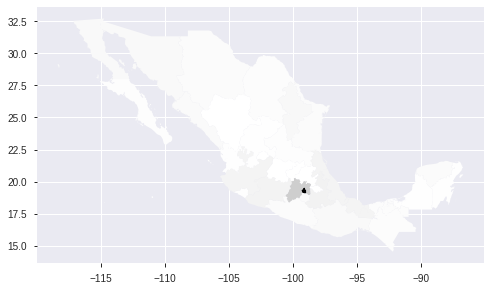

,geometry,ENTIDAD,name
09,"POLYGON ((-99.17558 19.53065, -99.17568 19.530...",DISTRITO FEDERAL,32348.0
15,"POLYGON ((-99.84262 20.28271, -99.83584 20.276...",MEXICO,9922.0
21,"POLYGON ((-97.71801 20.79619, -97.71821 20.796...",PUEBLA,3913.0
16,"POLYGON ((-102.18245 18.00068, -102.18241 17.9...",MICHOACAN DE OCAMPO,3680.0
16,"POLYGON ((-102.78492 18.08120, -102.78574 18.0...",MICHOACAN DE OCAMPO,3680.0


In [71]:
df_ent = df_ten.groupby('CVE_ENT').agg({'name':'count'})
df_ent = ent.set_index('NUM_EDO').join(df_ent, how='left')
df_ent.plot(column='name')
plt.show()
df_ent.sort_values('name', ascending=False).head()

/home/esther/anaconda3/envs/datascience/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


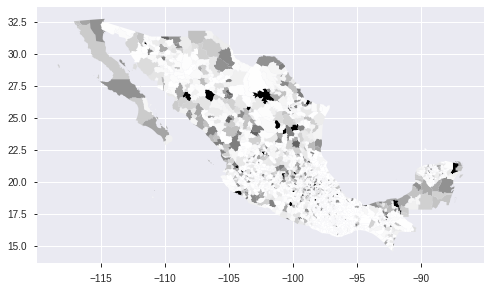

,CVE_ENT,NOM_MUN,OID_1,cov_,cov_id,geometry,name
CVE_MUN,,,,,,,
007,27,Emiliano Zapata,1954,1954,1955,"POLYGON ((-91.74511 17.94081, -91.73954 17.935...",3322.0
007,18,Jala,923,923,924,"POLYGON ((-104.23758 21.20223, -104.23868 21.2...",3322.0
007,31,Cacalchén,2367,2367,2368,"POLYGON ((-89.21142 21.03395, -89.21164 21.031...",3322.0
007,30,Camarón de Tejeda,2078,2078,2079,"POLYGON ((-96.56662 19.05094, -96.56547 19.050...",3322.0
007,29,El Carmen Tequexquitla,2017,2017,2018,"POLYGON ((-97.69714 19.39320, -97.69641 19.390...",3322.0
007,28,Camargo,1975,1975,1976,"POLYGON ((-99.02387 26.10410, -99.02463 26.106...",3322.0
007,26,Atil,1922,1922,1923,"POLYGON ((-111.55308 30.92873, -111.55510 30.9...",3322.0
007,25,Choix,1867,1867,1868,"POLYGON ((-108.47551 27.03995, -108.47501 27.0...",3322.0
007,24,Cedral,1855,1855,1856,"POLYGON ((-100.61340 24.17394, -100.58915 24.1...",3322.0


In [76]:
df_mun = df_ten.groupby('CVE_MUN').agg({'name':'count'})
df_mun = mun.set_index('CVE_MUN').join(df_mun, how='left')
df_mun.plot(column='name')
plt.show()
df_mun.sort_values('name', ascending=False).head(25)

A futuro: incluir patrones temporales y espaciales para mejorar la detección de "las favoritas" y "pueden con todas"

Gracias!